# Processing steps for RGS lightcurves and spectra

This notebook was written in order to generate RGS lightcurves of an observation of the XMM-Newton observatory. It relies on the HEASOFT and SAS software that can be downloaded from the official websites of ESA. 


<span style="color:red">WARNING</span>: This simple notebook was made to take an initial look at the products of the RGS observations and should be used for this use only. For instance, in the generation of the lightcurve the background does not get checked for flares, which is an important step in making meaningful lightcurves. Plus, in the complete analysis the spectrum is cut into pieces of 1000 s each, while in this notebook only the full spectrum is analysed.
The products to be used in a final report should be generated with the '.py' script, which performs all the necessary steps.

In [1]:
import os
import subprocess
import sys
import glob
from astropy.io import fits
from astropy.table import Table
import logging
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xspec
logging.basicConfig(level=logging.INFO)

MJDREF = 50814.0
target_REDSHIFT = 0.0308 #for Markarian 421

In [2]:
def run_command(command,verbose=True):
    """
     Execute a shell command with the stdout and stderr being redirected to a log file 
    """
    
    try:
        result = subprocess.run(command, shell=True, stdout=subprocess.PIPE, stderr=subprocess.STDOUT)
        retcode = result.returncode
        if retcode<0:
            if verbose:
                print(f"Execution of {command} was terminated by signal", -retcode, file=sys.stderr)
            logging.warning("Execution of {} was terminated by signal: {} \n {}".format(command,-retcode,result.stdout.decode()))
        else:
            if verbose:
                print(f"Execution of {command} returned", retcode, file=sys.stderr)
            logging.info("Execution of {} returned {}, \n {}".format(command,retcode,result.stdout.decode()))
    except OSError as e:
        print(f"Execution of {command} failed:", e, file=sys.stderr)
        logging.error("Execution of {} failed: {}".format(command,e))
    return retcode

In [3]:
def mask_fracexp15(fits_file):
    """
    For each light curve, checks the FRACEXP column of the FITS file given as argument. If the value
    is not at least 15%, the data point is discarded.
    Returns the time array, the rate array, the error rate array, the fracexp array, the background rate array,
    and the background error rate array. 
    """
    #Check FRACEXP column, the fractional exposure extension. If not at least 15%, discard the datapoint
    with fits.open(fits_file) as hdul:
        masknan = np.invert(np.isnan(hdul['RATE'].data['RATE']))
        fracexp = hdul['RATE'].data['FRACEXP'][masknan]
        time = hdul['RATE'].data['TIME'][masknan]
        rate = hdul['RATE'].data['RATE'][masknan]
        erate = hdul['RATE'].data['ERROR'][masknan]
        backv = hdul['RATE'].data['BACKV'][masknan]
        backe = hdul['RATE'].data['BACKE'][masknan]

        mask15 = fracexp >= 0.15
        
        time = time[mask15]
        rate = rate[mask15]
        erate = erate[mask15]
        fracexp = fracexp[mask15]
        backv = backv[mask15]
        backe = backe[mask15]
    return (time.byteswap().newbyteorder(), rate.byteswap().newbyteorder(), erate.byteswap().newbyteorder(),
             fracexp.byteswap().newbyteorder(), backv.byteswap().newbyteorder(), backe.byteswap().newbyteorder())

## Setting up XMM-SAS

This step consists mainly of defining the environment variables. This step is user-dependent, i.e. you will have to modify the paths according to where your SAS folders are. Here, the paths are those for the virtual machine image that can be downloaded from the ESA website: PUT WEBSITE.


Make sure you inizialized HEASOFT and SAS with the following commands:

`heainit`

`sasinit`

`source activate sas_18.0.0`


In [4]:
sas_dir = '/usr/local/SAS/xmmsas_20190531_1155'
os.environ["SAS_DIR"] = sas_dir
os.environ["SAS_PATH"] = os.environ["SAS_DIR"]
os.environ["SAS_CCF"] = '/ccf/valid'
!sasversion

sasversion:- Executing (routine): sasversion  -w 1 -V 4
sasversion:- sasversion (sasversion-1.3)  [xmmsas_20190531_1155-18.0.0] started:  2020-08-28T10:29:11.000
sasversion:- XMM-Newton SAS release and build information:

SAS release: xmmsas_20190531_1155-18.0.0
Compiled on: Sun Jun  2 14:11:18 CEST 2019
Compiled by: sasbuild@sasbld03n
Platform   : Ubuntu16.04 64

SAS-related environment variables that are set:

SAS_DIR = /usr/local/SAS/xmmsas_20190531_1155
SAS_PATH = /usr/local/SAS/xmmsas_20190531_1155
SAS_CCFPATH = /ccf/valid
SAS_CCF = /ccf/valid

sasversion:- sasversion (sasversion-1.3)  [xmmsas_20190531_1155-18.0.0] ended:    2020-08-28T10:29:11.000


## Setting up ODF and CCF for the observation

Assuming that the ODFs have already been downloaded and are in the Observation Id (ObsId) folder, I generate the 'ccf.cif' file for each observation.

In [5]:
# Setup observation directory and odf directory 
obs_id = '0150498701'
obs_dir = f'/media/xmmsas/thesis/Markarian421/{obs_id}'    #EXAMPLE OBSERVATION
odf_dir = os.path.join(obs_dir, 'odf')
os.environ["SAS_ODF"] = odf_dir
os.chdir(obs_dir)

# Generate the Calibration Index File (cif) in working directory and set the 'SAS_CCF' variable pointing to it
if not glob.glob('ccf.cif'):
    ccf_command = "cifbuild"
    ccf_status = run_command(ccf_command)
    if (ccf_status != 0):
        raise Exception    
os.environ["SAS_CCF"] = os.path.join(obs_dir, 'ccf.cif')
logging.info(f"SAS_CCF pointing to {os.path.join(obs_dir, 'ccf.cif')}")

# Generate the SUM.ASC file, that summarizes all the observational info and set 'SAS_ODF' variable pointing to it
if not glob.glob('*SUM.SAS'):
    odf_command = "odfingest"
    odf_status = run_command(odf_command)
    if (odf_status != 0):
        raise Exception
sum_odf_dir = glob.glob('*SUM.SAS')[0]
os.environ["SAS_ODF"] = os.path.join(obs_dir, sum_odf_dir)
logging.info(f"SAS_ODF pointing to {os.path.join(obs_dir, sum_odf_dir)}")

INFO:root:SAS_CCF pointing to /media/xmmsas/thesis/Markarian421/0150498701/ccf.cif
INFO:root:SAS_ODF pointing to /media/xmmsas/thesis/Markarian421/0150498701/0720_0150498701_SCX00000SUM.SAS


## Processing and reducing RGS data

This step is simply done by the SAS command `rgsproc`. The outputs can be found in the rgs directory of each observation.

In [6]:
rgs_dir = os.path.join(obs_dir, 'rgs')
os.chdir(rgs_dir)

#Check if the data has already been processed: if not, run the command.
if not glob.glob('*EVENLI0000.FIT'):
    rgs_command = 'rgsproc > my_rgsproc_logfile'
    rgs_status = run_command(rgs_command)
    if (rgs_status != 0):
        raise Exception
evlists = glob.glob('*EVENLI0000.FIT')
srclists = glob.glob('*SRCLI_0000.FIT')
respli = glob.glob('*RSPMAT1*')
total_spectra = glob.glob('*SRSPEC1*')
total_bkgr = glob.glob('*BGSPEC1*')

## Extraction and correction of RGS X-ray lightcurve
The `rgsproc` command produces files named as  'PxxxxxxyyyyRrzeeettttttosss.FIT', where

xxxxxx	proposal number


yyyy	observation number


r	1 for RGS1, 2 for  RGS2


z	S for 'scheduled' exposures, U for 'unscheduled' exposures


eee	exposure number: from 001 to 999


tttttt	type of file (events, spectrum, etc)


o	1 for first order, 2 for second order, 0 if not applicable


sss	source number, when applicable.


To make one lightcurve we need the RGS1 and RGS2 event and source lists. Note that for each lightcurve the RGS1 and RGS2 exposure numbers are consecutive, so we will need to sort the products according to the exposure number.

In [7]:
def split_rgs_filename(filename):
    """
    Splits the RGS filname in substrings, each of which indicate a specific characteristic of the observation.
    Returns the dictionary of the substrings.
    """
    n = [1, 10, 2, 1, 3, 6, 1, 3]
    split_name = (([filename[sum(n[:i]):sum(n[:i+1])] for i in range(len(n))]))
    
    instr = split_name[2]
    exposure = split_name[3]
    expo_number = split_name[4]
    type_file = split_name[5]
    order = split_name[6]
    source_number = split_name[7]
    
    return {"instr":instr, "exposure": exposure, "expo_number":expo_number, "type_file":type_file, "order":order, "source_number":source_number, "filename": filename}

In [8]:
def sort_rgs_list(l, variable):
    """
    Given a list of rgs products of the same type (e.g. 'EVENLI' or 'SRCLI_') this function sorts the list according
    to the exposure number so that the list can be divided into pairs ready for the generation of the lightcurves.
    """
    
    #Make a list of dictionaries associated to each event
    l_dict = []
    for ele in l:
        l_dict.append(split_rgs_filename(ele))
     
    #Sort the list according to the exposure number
    sorted_l_dict = sorted(l_dict, key=lambda k: k[variable])
    
    #Reassemble the filenames and split the sorted list into pairs made up of an RGS1 and a RGS2 with consecutive
    #exposure numbers
    sorted_l = []
    for ele in sorted_l_dict:
        sorted_l.append(ele['filename'])
    return [sorted_l[x:x+2] for x in range(0, len(sorted_l), 2)]


#Sort eventlists
pairs_events = sort_rgs_list(evlists, 'expo_number')
print('EVENT LISTS:', pairs_events)

#Sort sourcelists
pairs_srcli = sort_rgs_list(srclists, 'expo_number')
print('SOURCE LISTS:', pairs_srcli)

#Sort response matrix
pairs_respli = sort_rgs_list(respli, 'expo_number')
print('RESPONSE MATRIX LISTS:', pairs_respli)

#Sort spectra
pairs_specli = sort_rgs_list(total_spectra, 'expo_number')
print('SPECTRA LISTS:', pairs_specli)

#Sort spectra background
pairs_bkgr = sort_rgs_list(total_bkgr, 'expo_number')
print('BACKGROUND SPECTRA LISTS:', pairs_bkgr)

EVENT LISTS: [['P0150498701R1S004EVENLI0000.FIT', 'P0150498701R2S005EVENLI0000.FIT']]
SOURCE LISTS: [['P0150498701R1S004SRCLI_0000.FIT', 'P0150498701R2S005SRCLI_0000.FIT']]
RESPONSE MATRIX LISTS: [['P0150498701R1S004RSPMAT1003.FIT', 'P0150498701R2S005RSPMAT1003.FIT']]
SPECTRA LISTS: [['P0150498701R1S004SRSPEC1003.FIT', 'P0150498701R2S005SRSPEC1003.FIT']]
BACKGROUND SPECTRA LISTS: [['P0150498701R1S004BGSPEC1003.FIT', 'P0150498701R2S005BGSPEC1003.FIT']]


# Making, plotting and saving the lightcurve 

The making of the lightcurve is done by running the SAS command 'rgslccorr' for the pair of RGS1 and RGS2 exposures.
The plotting is done using the matplotlib package and results in a plot with two panels: the top panel will contain the source lightcurve, the bottom contains the background lightcurve. The time axis is shared among the panels and is converted into MJD (days). The average rate is also shown as a horizontal line in the source lightcurve.

INFO:root:The lightcurve 0150498701_004+005_RGS_rates.ds will be plotted with matplotlib.


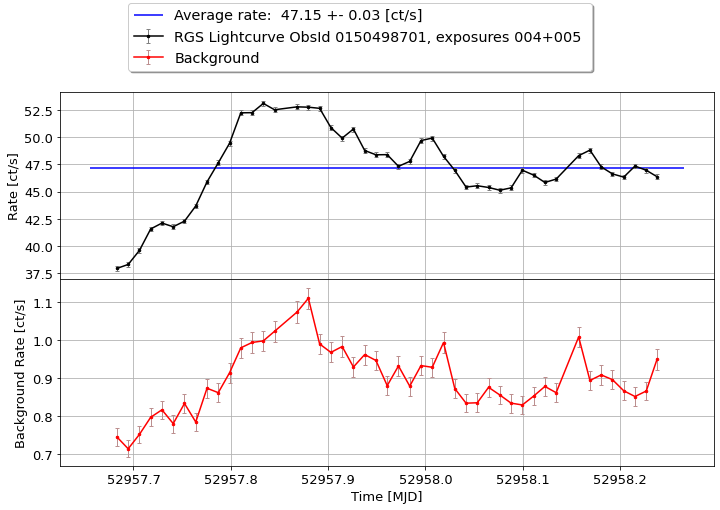

INFO:root:The lightcurve is saved as 0150498701_004+005_RGS_rates.ds.png


<Figure size 432x288 with 0 Axes>

In [9]:
for filename in glob.glob('*_RGS_rates.ds'):
    output_name = filename

    try:
        logging.info(f'The lightcurve {output_name} will be plotted with matplotlib.')

        #Extract data from the lightcurve fits file produced with rgslccorr and drop NaN values by making a numpy mask
        x, y, yerr, fracexp, y_bg, yerr_bg = mask_fracexp15(output_name)

        #Store average rate and weighted error of mean
        avg_rate = np.mean(y)
        stdev_rate = np.sqrt(1/(np.sum(1/np.square(yerr))))  

        #Conversion in MJD (note that 86400 are the seconds in one day)
        x_mjd = MJDREF + (x/86400.0)

        #Plot data: 1 panel for source lc, one panel for background lc
        fig, axs = plt.subplots(2, 1, figsize=(10,6), sharex=True, gridspec_kw={'hspace':0})
        axs[0].errorbar(x_mjd, y, yerr=yerr, color='black', fmt='.', elinewidth=1, capsize=2, capthick=1, markersize=5, linestyle='-', ecolor='gray', label=f'RGS Lightcurve ObsId {obs_id}, exposures {output_name[11:18]} ')
        axs[0].grid(True)
        axs[0].ticklabel_format(useOffset=False)
        axs[0].set_ylabel('Rate [ct/s]', fontsize=13)
        axs[0].hlines(avg_rate, plt.xlim()[0], plt.xlim()[1], colors='b', label=f'Average rate: {avg_rate: .2f} +- {stdev_rate:.2f} [ct/s]')
        axs[0].tick_params(axis='both', which='major', labelsize=13)

        axs[1].errorbar(x_mjd, y_bg, yerr=yerr_bg, color='red',fmt='.', elinewidth=1, capsize=2, capthick=1, markersize=5, linestyle='-', ecolor='rosybrown', label=f'Background')
        axs[1].set_xlabel('Time [MJD]', fontsize=13)
        axs[1].ticklabel_format(useOffset=False)
        axs[1].set_ylabel('Background Rate [ct/s]', fontsize=13)
        axs[1].grid(True)
        axs[1].tick_params(axis='both', which='major', labelsize=13)

        #Magic trick for the legend
        lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
        lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
        fig.legend(lines, labels, loc='lower center', bbox_to_anchor=(0.5, 1), fontsize='x-large', fancybox=True, shadow=True)
        plt.tight_layout()
        #Save figure in rgs directory of the current Observation
        plt.show()
        plt.savefig(f'{output_name}.png')
        logging.info(f'The lightcurve is saved as {output_name}.png')

    except Exception as e:
        logging.error(e)

# Variability quantities

Here we calculate the excess variance, the variability amplitude and the fractional variability of the lightcurve.

In [10]:
def excess_variance(rates, errrates, normalized=True):
    """
    Calculates the excess variance from the rates given as argument. 
    If normalized = True, the function returns the normalized excess variance and its error.
    
    :param rates: rate lightcurve [ct/s]
    :param errrates: error on rates
    :param normalized: if set to True, returns the normalized excess variance otherwise returns the excess variance.
    """

    try:
        mean = np.mean(rates)
        if mean<0:
            raise ValueError('Negative count rates in Input File.')
    except ValueError as e:
        loggng.error(e)

    #Calculation of excess variance beginning from the rates (definitions taken from Aggrawal et al., 2018)
    variance = np.var(rates, ddof=1)     #variance
    N = len(rates)
    mse = np.mean(np.square(errrates))   #mean square error
    xs = variance - mse                 #excess variance
    nxs = xs/(np.square(mean))          #normalized excess variance
    f_var = np.sqrt(nxs)                #fractional variability

    # Errors on excess variance (taken from Vaughan et al., 2003)
    err_xs = np.sqrt(2*np.square(mse)/N + 4*mse*np.square(xs)/N)
    if nxs>0:
        err_nxs = np.sqrt( np.square(np.sqrt(2/N)*mse/np.square(mean)) + np.square(np.sqrt(mse/N) *2*f_var/mean) )
    else:
        err_nxs = np.sqrt(2/N) * (mse/np.square(mean))

    if normalized:
        return nxs, err_nxs
    else:
        return xs, err_xs


def fractional_variability(rates, errrates, backv, backe, netlightcurve=True, consider_upper_lims=False):
    """
    Returns the fractional variability and its error given the rates and error rates as arguments.
    The fractional variability is the root square of excess variance, so if the excess variance is negative,
    the functions sets the fractional variability and its error automatically to -1.

    :param rates: rate lightcurve [ct/s]
    :param errrates: error on rates
    :param backv: background rate lightcurve
    :param backe: errors on background  rate
    :param netlightcurve: if set to True, consider the net lightcurve, if set to False consider the total (source+background) lightcurve
    """
    if netlightcurve:
        nxs, err_nxs = excess_variance(rates, errrates, True)
        
        #A value of -1 indicates that the noise of the data is much greater than the scatter of the data.
        if nxs<0:
            if consider_upper_lims:
                nxs = nxs + err_nxs*1.64
                f_var = np.sqrt(nxs)
                err_fvar = 1/(2*f_var) * err_nxs
            else:
                f_var = -1.
                err_fvar = -1.
        else:
            f_var = np.sqrt(nxs)
            err_fvar = 1/(2*f_var) * err_nxs
    else:
        total_rate = rates + backv
        total_errates = np.sqrt( np.square(errrates) + np.square(backe) )
        nxs, err_nxs = excess_variance(total_rate, total_errates, True)
        f_var = np.sqrt(nxs)
        err_fvar = 1/(2*f_var) * err_nxs

    return f_var, err_fvar


In [11]:
#Initialize list of dictionaries that will contain the variability quantities (one dict for each lightcurve)
fracvardict = []
i = 0
for filename in glob.glob('*_RGS_rates.ds'):
        timeseries = filename

        try:
            #Get dataset(s) and table.
            with fits.open(timeseries) as hdul:
                header = hdul['RATE'].header
                astro_table = Table(hdul['RATE'].data)
                dataset = astro_table.to_pandas()
                dataset = dataset.sort_values(by=['TIME'])

        except Exception as e:
            logging.error(e)


        #Delete gaps in data 
        dataset_cleaned = dataset.dropna()

        #Net source rates and errors and background rates and errors are recorded in arrays
        numnonnull = len(dataset_cleaned)
        rates = np.array(dataset_cleaned['RATE'])
        errrates = np.array(dataset_cleaned['ERROR'])
        backv = np.array(dataset_cleaned['BACKV'])
        backe = np.array(dataset_cleaned['BACKE'])
        time = np.array(dataset_cleaned['TIME'])

        #Calculate Variability parameters and respective errors
        xs, err_xs = excess_variance(rates, errrates, normalized=False)
        nxs, err_nxs = excess_variance(rates, errrates, normalized=True)
        f_var, err_fvar = fractional_variability(rates, errrates, backv, backe, netlightcurve=True)
        va = (max(rates) - min(rates))/ (min(rates))
        err_va = va* ( (errrates[rates.argmax()] + errrates[rates.argmin()])/(max(rates) - min(rates)) +  (errrates[rates.argmin()] / min(rates) ))

        fracvardict.append({"Excess variance": xs, "Excess variance error": err_xs, "Normalized excess variance": nxs,
                            "Normalized excess variance error": err_nxs, "Fractional Variability": f_var, 
                            "Fractional Variability Error": err_fvar,
                            "Variability Amplitude": va, "Variability amplitude error": err_va,
                            "Number of non null data points": numnonnull})

        #Print variability test results.
        for key, value in fracvardict[i].items():
            print(key, ' : ', value)
        i+=1

Excess variance  :  19.359316
Excess variance error  :  5.9091539177721994
Normalized excess variance  :  0.008904755
Normalized excess variance error  :  0.0006262984133152469
Fractional Variability  :  0.09436501
Fractional Variability Error  :  0.003318488629552703
Variability Amplitude  :  0.7512282
Variability amplitude error  :  0.35327742
Number of non null data points  :  49


# Making and plotting of RGS spectrum

In [12]:
def spectrum_plot_xspec(observation, n, model, rgs_dir, i=0):
    """
    Plot spectrum in PyXspec.
    """
    xspec.Plot.device = '/null'
    xspec.Plot.xAxis = 'keV'
    xspec.Plot.setRebin(minSig=3, maxBins=4096) 
    xspec.Plot.background = True
    xspec.Plot('data')

    # Use matplotlib
    # Store x and y for RGS1 and RGS2
    chans1 = xspec.Plot.x(1)
    chans1_err = xspec.Plot.xErr(1)
    rates1 = xspec.Plot.y(1)
    rates1_err = xspec.Plot.yErr(1)
    chans2 = xspec.Plot.x(2)
    chans2_err = xspec.Plot.xErr(2)
    rates2 = xspec.Plot.y(2)
    rates2_err = xspec.Plot.yErr(2)

    fig, axs = plt.subplots(3, 1, sharex=True, gridspec_kw={'hspace':0.1}, figsize=(20,15))
    if i==0:
        fig.suptitle(f"Average spectra {observation}, Pair {n}, {model} ", fontsize=25, y=0.92)
    else:
        fig.suptitle(f"{observation} Pair {n} {model} Part {i}", fontsize=25, y=0.92)

    # First panel: Source Spectrum
    axs[0].errorbar(chans1, rates1, yerr=rates1_err, xerr=chans1_err, linestyle='', color='black', label='RGS1')
    axs[0].errorbar(chans2, rates2, yerr=rates2_err, xerr=chans2_err, linestyle='', color='red', label='RGS2')
    
    # First panel: Background Spectrum
    xspec.Plot('back')
    axs[0].errorbar(chans1, xspec.Plot.y(1), xerr=chans1_err, yerr=xspec.Plot.yErr(1), color='wheat', linestyle='', marker='.', markersize=0.2, label='Background RGS1')
    axs[0].errorbar(chans2, xspec.Plot.y(2), xerr=chans2_err, yerr=xspec.Plot.yErr(2), color='tan', linestyle='', marker='.', markersize=0.2, label='Background RGS2')
    
    #axs[0].set_yscale('log')
    axs[0].set_xscale('log')
    #axs[0].set_ylim(1e-7)
    axs[0].set_xlim(0.331, 2.001)
    axs[0].set_ylabel('Normalized counts [s-1 keV-1]', fontsize=17)
    axs[0].legend(loc='upper right', fontsize='x-large')

    # Second panel: Residuals
    xspec.Plot('resid')
    axs[1].errorbar(chans1, xspec.Plot.y(1), yerr=xspec.Plot.yErr(1), linestyle='', color='black', label='RGS1')
    axs[1].errorbar(chans2, xspec.Plot.y(2), yerr=xspec.Plot.yErr(2), linestyle='', color='red', label='RGS2')
    axs[1].hlines(0, plt.xlim()[0], plt.xlim()[1], color='lime')   
    axs[1].set_ylabel('Normalized counts [s-1 keV-1]', fontsize=17)

    # Third panel: delchi
    xspec.Plot('delchi')
    axs[2].errorbar(chans1, xspec.Plot.y(1), yerr=1., linestyle='', color='black', label='RGS1')
    axs[2].errorbar(chans2, xspec.Plot.y(2), yerr=1., linestyle='', color='red', label='RGS2')
    axs[2].hlines(0, plt.xlim()[0], plt.xlim()[1], color='lime')  
    axs[2].set_xlabel('Energy [keV]', fontsize=17)
    axs[2].set_ylabel('(data-model)/error', fontsize=17)

    if i==0:
        plt.savefig(f"{rgs_dir}/average_{observation}_{n}_{model}.png")
        plt.show()
    else:
        plt.savefig(f"{rgs_dir}/{observation}_{n}_{model}_{i}.png")
        plt.show()
    plt.close()


INFO:root:Starting RGS spectral analysis with XSPEC for observation 0150498701 (total spectra).


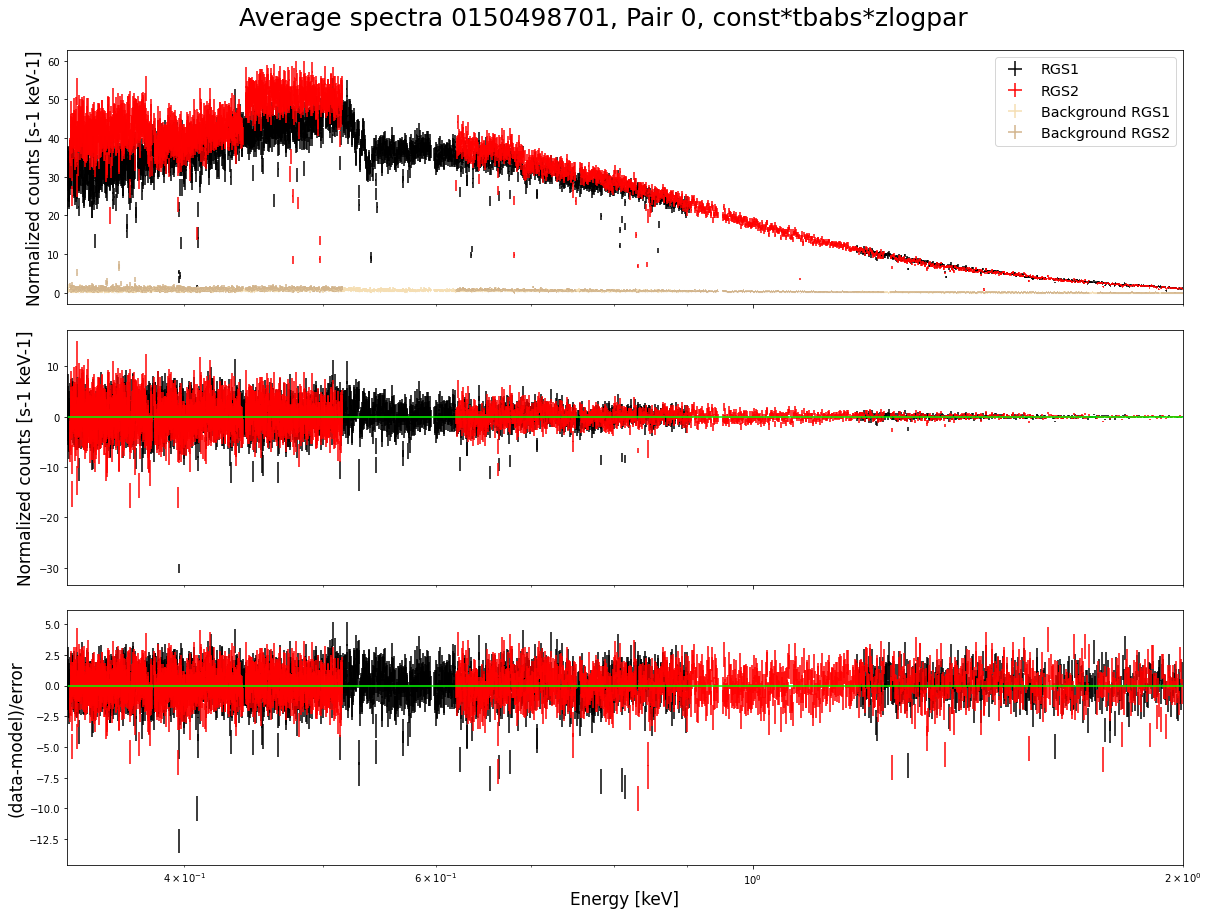

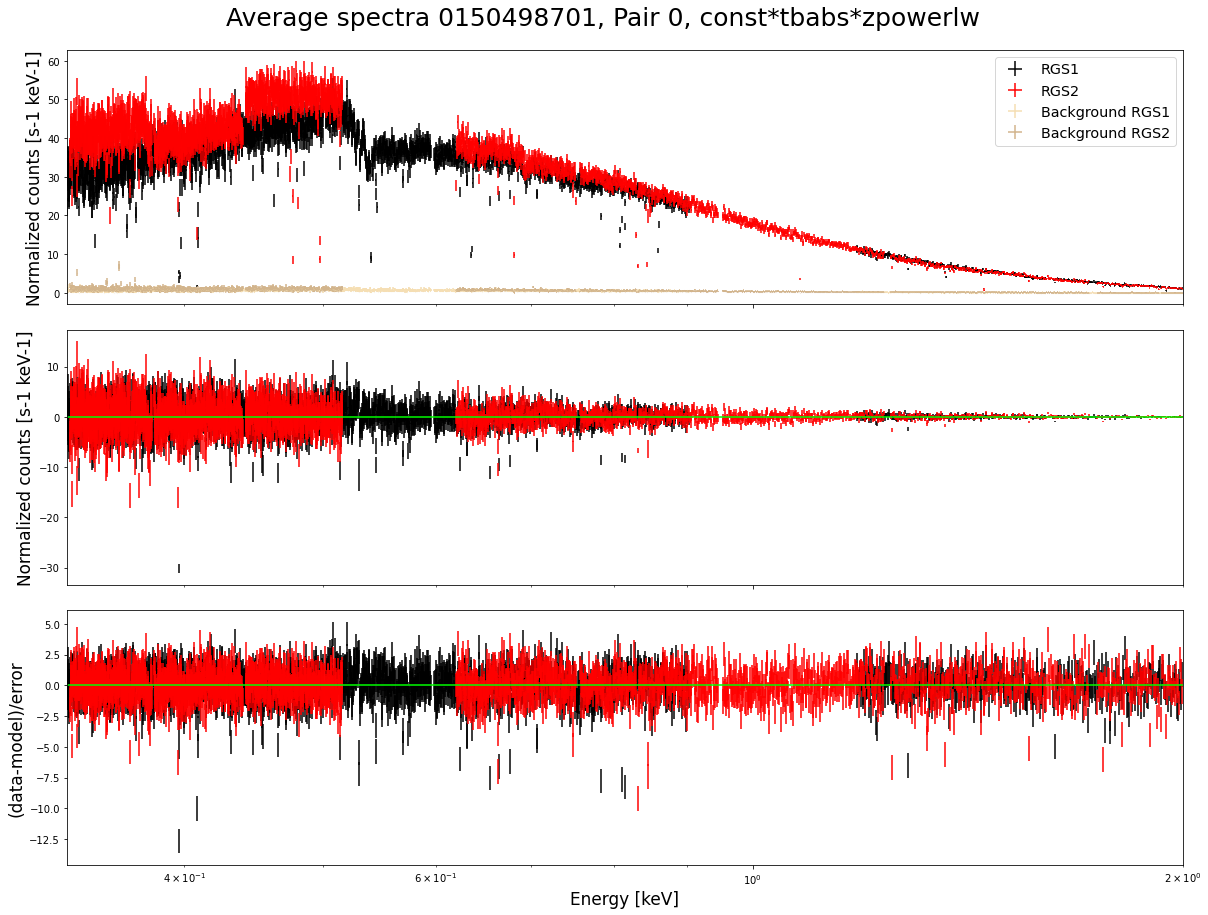

INFO:root:Done total spectral analysis. Please check your rgs directory.


In [13]:
if not glob.glob(f'{rgs_dir}/average_*.png'):          
    logging.info(f"Starting RGS spectral analysis with XSPEC for observation {obs_id} (total spectra).")
    os.chdir(rgs_dir)

    # Create Table that we will fill with the output (parameters, flux, luminosity...)
    spectra_table = Table(names=('obsid', 'instrid', 'pair_exposure',
                                'tbinid', 'exposure', 'model',
                                'nH', 'nH_low', 'nH_up', 'nH_low68', 'nH_up68', 
                                'phoindex', 'phoindex_low', 'phoindex_up', 'phoindex_low68', 'phoindex_up68',
                                'beta', 'beta_low', 'beta_up', 'beta_low68', 'beta_up68', 
                                'norm', 'norm_low', 'norm_up', 'norm_low68', 'norm_up68',
                                'cstat', 'chi2', 'dof', 
                                'src_cts', 'esrc_cts', 'bkg_cts', 'ebkg_cts',
                                'rate', 'erate', 
                                'flux', 'flux_up', 'flux_low',
                                'lumin', 'lumin_up', 'lumin_low'
                                ),
                                dtype=('i','U9', 'U9',
                                    'i', 'd','U20',
                                    'd','d', 'd','d', 'd',
                                    'd','d', 'd','d', 'd',
                                    'd','d','d','d', 'd', 
                                    'd','d','d','d', 'd', 
                                    'd','d','i', 
                                    'd', 'd', 'd', 'd',
                                    'd', 'd',
                                    'd', 'd', 'd', 
                                    'd', 'd', 'd'))


    # Xspec models we want to use for fitting
    model_list = ['const*tbabs*zlogpar', 'const*tbabs*zpowerlw']  

    for i in range(len(pairs_specli)):
        
        #Load RGS1 + RGS2 data                
        os.chdir(rgs_dir)
        xspec.AllData(f"1:1 {pairs_specli[i][0]} 2:2 {pairs_specli[i][1]}")
        

        spectrum1 = xspec.AllData(1)
        spectrum1.background = f"{pairs_bkgr[i][0]}"
        spectrum1.response = f"{pairs_respli[i][0]}"

        spectrum2 = xspec.AllData(2)
        spectrum2.background = f"{pairs_bkgr[i][1]}"
        spectrum2.response = f"{pairs_respli[i][1]}"

        
        # Ignore bad channels
        xspec.AllData.ignore("bad")
        xspec.AllData.ignore('**-0.331 2.001-**')

        for model in model_list:
            m1 = xspec.Model(model)
            m2 = xspec.AllModels(2) #Retrieve the model object assigned to data group 2

            if m1.expression=='constant*TBabs*zlogpar':
                m1.setPars("1.0 -1", {5:0.331, 6:0.0308})
                m2.setPars("1.0", "/*")

            if m1.expression=='constant*TBabs*zpowerlw':
                m1.setPars("1.0 -1", {4:0.0308})
                m2.setPars("1.0", "/*")

            xspec.AllModels.show()

            #Perform Fit using cstat as statistic for parameter estimation
            xspec.Fit.statMethod = "cstat" 
            xspec.Fit.statTest = "pchi"
            xspec.Fit.renorm()    #renormalize model to minimize statistic with current parameters
            xspec.Fit.query = 'yes'
            xspec.Fit.perform() 

            #Error calculation (confidence intervals 3 sigma, 90% confidence)
            if m1.expression=='constant*TBabs*zlogpar':
                xspec.Fit.error("stopat 1000,, maximum 1000.0 2.706 2,3,4,7")   

            if m1.expression=='constant*TBabs*zpowerlw':
                xspec.Fit.error("stopat 1000,, maximum 1000.0 2.706 2,3,5")

            #Plot
            spectrum_plot_xspec(obs_id, i, model, rgs_dir, 0)

            #Calculate Flux and Luminosity and store their values 
            xspec.AllModels.calcFlux('0.331 2.001 err 100 90')
            xspec.AllModels.calcLumin(f'0.331 2.001 {target_REDSHIFT} err') 
            flux = spectrum1.flux[0] #erg/cm2/s
            lumin = spectrum1.lumin[0] #e+44 erg/s
            flux_up = spectrum1.flux[2]
            flux_low = spectrum1.flux[1]
            lumin_up = spectrum1.lumin[2]
            lumin_low = spectrum1.lumin[1]

            #Store parameter results of fit
            if m1.expression=='constant*TBabs*zpowerlw':
                nH = m1(2).values[0]
                phoindex = m1(3).values[0]
                norm = m1(5).values[0]

                #Confidence intervals 90%
                nH_low = m1(2).error[0]
                nH_up = m1(2).error[1]
                phoindex_low = m1(3).error[0]
                phoindex_up = m1(3).error[1]
                norm_low = m1(5).error[0]
                norm_up = m1(5).error[1]
                beta, beta_up, beta_low = (np.nan, np.nan, np.nan)

                #Confidence intervals 68%
                xspec.Fit.error("stopat 1000,, maximum 1000.0 1.0 2,3,5")
                nH_low68 = m1(2).error[0]
                nH_up68 = m1(2).error[1]
                phoindex_low68 = m1(3).error[0]
                phoindex_up68 = m1(3).error[1]
                norm_low68 = m1(5).error[0]
                norm_up68 = m1(5).error[1]
                beta, beta_up68, beta_low68 = (np.nan, np.nan, np.nan)


            if m1.expression=='constant*TBabs*zlogpar':
                nH = m1(2).values[0]
                phoindex = m1(3).values[0]
                beta = m1(4).values[0]
                norm = m1(7).values[0]

                #Confidence intervals 90%
                nH_low = m1(2).error[0]
                nH_up = m1(2).error[1]
                phoindex_low = m1(3).error[0]
                phoindex_up = m1(3).error[1]
                beta_low = m1(4).error[0]
                beta_up = m1(4).error[1]
                norm_low = m1(7).error[0]
                norm_up = m1(7).error[1]

                #Confidence intervals 68%
                xspec.Fit.error("stopat 1000,, maximum 1000.0 1.0 2,3,4,7") 
                nH_low68 = m1(2).error[0]
                nH_up68 = m1(2).error[1]
                phoindex_low68 = m1(3).error[0]
                phoindex_up68 = m1(3).error[1]
                beta_low68 = m1(4).error[0]
                beta_up68 = m1(4).error[1]
                norm_low68 = m1(7).error[0]
                norm_up68 = m1(7).error[1]

            fit_statistic = xspec.Fit.statistic
            test_statistic = xspec.Fit.testStatistic
            dof = xspec.Fit.dof

            # Retrieve rates and counts from xspec
            exposure_time = max(spectrum1.exposure, spectrum2.exposure)
            src_rate = spectrum1.rate[0] + spectrum2.rate[0]  #net rate
            src_rate_std = spectrum1.rate[1] + spectrum2.rate[1]
            frac = spectrum1.rate[2] + spectrum2.rate[2] #total rate

            src_cts = spectrum1.exposure*spectrum1.rate[0] + spectrum2.exposure*spectrum2.rate[0]
            src_ects = spectrum1.exposure*spectrum1.rate[1] + spectrum2.exposure*spectrum2.rate[1] 
            bkg_cts = (1. - frac/100) *src_cts
            bkg_ects = (1. - frac/100) *src_ects

            #Save output table
            spectra_table.add_row((obs_id, "rgs12", i, 0,  exposure_time, m1.expression, nH, nH_low, nH_up,
                                nH_low68, nH_up68, phoindex, phoindex_low, phoindex_up, phoindex_low68, phoindex_up68,
                                beta, beta_low, beta_up, beta_low68, beta_up68, norm, norm_low, norm_up, norm_low68, norm_up68,
                                fit_statistic, test_statistic,
                                dof, src_cts, src_ects, bkg_cts, bkg_ects, src_rate, src_rate_std, 
                                flux, flux_up, flux_low, lumin, lumin_up, lumin_low))


    # Close XSPEC's currently opened log file.
    xspec.Xset.closeLog()

    # Write FITS output file 
    if glob.glob(f'{rgs_dir}/{obs_id}_table.fits'):
        os.remove(glob.glob(f'{rgs_dir}/{obs_id}_table.fits')[0])

    spectra_table.write(f'{rgs_dir}/{obs_id}_table.fits', format='fits', overwrite=True)
    logging.info('Done total spectral analysis. Please check your rgs directory.')
else:
    logging.info('Spectral analysis on total spectrum already performed.')
